# Make cannonical processed data

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import dotenv
import os
import glob

import sys

import pprint

import matplotlib.pyplot as plt

import typing
import pandas as pd
import time

project_dir = str(os.path.dirname(os.path.abspath('')))
sys.path.append(project_dir)
# print(project_dir)



from src.data import scrape_rolling_stone as scrapeRS # import local scripts



from src.data import get_spotify_api_data as gsad

from src.data import process_spotify_data as psd

from src.data.pickle_util import save_pickle, load_pickle



import datetime

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV




## Load data

Load dataframe of information from spotify

In [2]:
base_path = project_dir + '/data/interim/'
file_name = 'df_spotify_album_data.csv'
df_spotify_album_data = pd.read_csv(base_path + file_name)

In [3]:
df_spotify_album_data

,title_cleaned,album_id,release_date,duration,total_tracks,avg_vol
0,Indigo,1BfLzaTFI5qKsAAk0Ae6aV,1.561698e+09,7423978.0,32.0,-5.265031
1,"When We All Fall Asleep, Where Do We Go?",0S0KGZnfBGSIssfF54WSJh,1.553836e+09,2575261.0,14.0,-15.085071
2,Let's Rock,0aA9rYw8PEv9G7tVIJ9dKg,1.561698e+09,2314230.0,12.0,-6.701583
3,7 EP,4IRiXE5NROxknUSAUSjMoO,1.561093e+09,1128730.0,8.0,-6.646625
4,Free Spirit,6KT8x5oqZJl9CcnM66hddo,1.554440e+09,3442262.0,17.0,-9.121000
...,...,...,...,...,...,...
595,The Cars,4tJPWT4r4FSKwy784Qs1Fq,2.659572e+08,2122649.0,9.0,-8.955556
596,Eddie Money,5gMrkmI53zEn98WDwU0iye,2.209464e+08,2365371.0,10.0,-12.803000
597,The Fall of Hobo Johnson,3QrkHSj8pBzE1Kwhpnktkw,1.568351e+09,2253807.0,12.0,-7.243167
598,Complete Greatest Hits,6ooUxOl89UHr11ADJjGQlH,1.014098e+09,4781086.0,20.0,-8.818150


load dataframe of year of rolling stone top 200 listings

In [4]:
directory = project_dir + '/data/interim/'
file_name = 'rs_200_albums_year_2019_cleaned.csv'
file_path = directory + file_name
rs_200_year_df = pd.read_csv(file_path)

In [5]:
rs_200_year_df

,rank,title,caption_artist,album_units,record_label,title_cleaned
0,1,Indigo,Chris Brown,110.4K,RCA Records,Indigo
1,2,"When We All Fall Asleep, Where Do We Go?",Billie Eilish,50.9K,Interscope,"When We All Fall Asleep, Where Do We Go?"
2,3,Let's Rock,The Black Keys,47.6K,Nonesuch Records,Let's Rock
3,4,7 EP,Lil Nas X,42.8K,Columbia Records,7 EP
4,5,Free Spirit,Khalid,37.3K,RCA Records,Free Spirit
...,...,...,...,...,...,...
10990,196,Artist,A Boogie wit da Hoodie,3.6K,Atlantic Records,Artist
10991,197,Different 'Round Here,Riley Green,3.5K,BMLG Records,Different 'Round Here
10992,198,Culture,Migos,3.5K,300 Entertainment,Culture
10993,199,Night Visions,Imagine Dragons,3.5K,Interscope,Night Visions


In [6]:
rs_200_year_df.columns

Index(['rank', 'title', 'caption_artist', 'album_units', 'record_label',
       'title_cleaned'],
      dtype='object')

drop title (because we have cleaned title)

In [7]:
rs_200_year_df = rs_200_year_df.drop(columns='title')

Convert xxK album units to floats representing 1000 album units

In [8]:
rs_200_year_df.album_units = (rs_200_year_df.album_units.str.replace('K', '')).astype('float')

In [9]:
rs_200_year_df

,rank,caption_artist,album_units,record_label,title_cleaned
0,1,Chris Brown,110.4,RCA Records,Indigo
1,2,Billie Eilish,50.9,Interscope,"When We All Fall Asleep, Where Do We Go?"
2,3,The Black Keys,47.6,Nonesuch Records,Let's Rock
3,4,Lil Nas X,42.8,Columbia Records,7 EP
4,5,Khalid,37.3,RCA Records,Free Spirit
...,...,...,...,...,...
10990,196,A Boogie wit da Hoodie,3.6,Atlantic Records,Artist
10991,197,Riley Green,3.5,BMLG Records,Different 'Round Here
10992,198,Migos,3.5,300 Entertainment,Culture
10993,199,Imagine Dragons,3.5,Interscope,Night Visions


Set all but the first 6 most common record labels to other

In [10]:
rs_200_year_df.loc[((rs_200_year_df.record_label != 'Interscope')
      & (rs_200_year_df.record_label != 'Atlantic Records')
      & (rs_200_year_df.record_label != 'Columbia Records')
      & (rs_200_year_df.record_label != 'Republic')
      & (rs_200_year_df.record_label != 'Capitol')
      & (rs_200_year_df.record_label != 'RCA Records')),
                             'record_label' ]= 'other'

Establish `rank_score` as a derived feature: it assigns 200 points for rank 1, down to 1 point for rank 200

In [11]:
rs_200_year_df['rank_score'] = 201 - rs_200_year_df['rank']

## group rolling stone dataframe by album

groupby cleaned title and aggregate sum of rank_score

In [12]:
groupby_title_sum = rs_200_year_df.groupby('title_cleaned').rank_score.sum()

incorporate the sum of rank score into the main dataframe

In [13]:
for title in groupby_title_sum.index:
    rs_200_year_df.loc[rs_200_year_df.title_cleaned==title,'year_rank_score'] = groupby_title_sum[title]

Also, groupby 'title_cleaned' and aggregate sum of album units

In [14]:
groupby_title_sum_album_units = rs_200_year_df.groupby('title_cleaned').album_units.sum()

incorporate the sum of album units in the the full dataframe

In [15]:
for title in groupby_title_sum.index:
    rs_200_year_df.loc[rs_200_year_df.title_cleaned==title,'year_album_units'] = groupby_title_sum_album_units[title]

Now, group the whole think by title_cleaned and take the firsts value.

In [16]:
groupby_first_rs_200_year_df = rs_200_year_df.groupby('title_cleaned').first().reset_index()

Inspect this result

In [17]:
groupby_first_rs_200_year_df

,title_cleaned,rank,caption_artist,album_units,record_label,rank_score,year_rank_score,year_album_units
0,!,65,Trippie Redd,9.3,other,136,1508.0,162.8
1,"- Ugh, those feels again",82,Snoh Aalegra,7.7,other,119,134.0,12.7
2,10 Day,153,Chance The Rapper,5.9,other,48,48.0,5.9
3,"10,000 Days",181,Tool,5.2,other,20,306.0,38.1
4,11:11,176,Maluma,5.3,other,25,25.0,5.3
...,...,...,...,...,...,...,...,...
606,"thank u, next",11,Ariana Grande,23.8,Republic,190,9394.0,822.7
607,uknowhatimsayin¿,154,Danny Brown,5.6,other,47,47.0,5.6
608,x,110,Ed Sheeran,7.0,Atlantic Records,91,2452.0,267.5
609,Épico,72,Lunay,9.1,other,129,271.0,27.8


The following columns are no longer meaningful: 'rank', 'album_units', 'rank_score'  
drop them

In [18]:
groupby_first_rs_200_year_df = groupby_first_rs_200_year_df.drop(columns=['rank', 'album_units', 'rank_score'])

put year_rank_score to data type of int

In [19]:
groupby_first_rs_200_year_df = groupby_first_rs_200_year_df.astype({'year_rank_score':'int64'})

In [20]:
groupby_first_rs_200_year_df

,title_cleaned,caption_artist,record_label,year_rank_score,year_album_units
0,!,Trippie Redd,other,1508,162.8
1,"- Ugh, those feels again",Snoh Aalegra,other,134,12.7
2,10 Day,Chance The Rapper,other,48,5.9
3,"10,000 Days",Tool,other,306,38.1
4,11:11,Maluma,other,25,5.3
...,...,...,...,...,...
606,"thank u, next",Ariana Grande,Republic,9394,822.7
607,uknowhatimsayin¿,Danny Brown,other,47,5.6
608,x,Ed Sheeran,Atlantic Records,2452,267.5
609,Épico,Lunay,other,271,27.8


Check data types:

In [21]:
groupby_first_rs_200_year_df.dtypes

title_cleaned        object
caption_artist       object
record_label         object
year_rank_score       int64
year_album_units    float64
dtype: object

## Merge rolling stone dataframe with spotify dataframe

First, inspect the two dataframes

In [22]:
df_spotify_album_data

,title_cleaned,album_id,release_date,duration,total_tracks,avg_vol
0,Indigo,1BfLzaTFI5qKsAAk0Ae6aV,1.561698e+09,7423978.0,32.0,-5.265031
1,"When We All Fall Asleep, Where Do We Go?",0S0KGZnfBGSIssfF54WSJh,1.553836e+09,2575261.0,14.0,-15.085071
2,Let's Rock,0aA9rYw8PEv9G7tVIJ9dKg,1.561698e+09,2314230.0,12.0,-6.701583
3,7 EP,4IRiXE5NROxknUSAUSjMoO,1.561093e+09,1128730.0,8.0,-6.646625
4,Free Spirit,6KT8x5oqZJl9CcnM66hddo,1.554440e+09,3442262.0,17.0,-9.121000
...,...,...,...,...,...,...
595,The Cars,4tJPWT4r4FSKwy784Qs1Fq,2.659572e+08,2122649.0,9.0,-8.955556
596,Eddie Money,5gMrkmI53zEn98WDwU0iye,2.209464e+08,2365371.0,10.0,-12.803000
597,The Fall of Hobo Johnson,3QrkHSj8pBzE1Kwhpnktkw,1.568351e+09,2253807.0,12.0,-7.243167
598,Complete Greatest Hits,6ooUxOl89UHr11ADJjGQlH,1.014098e+09,4781086.0,20.0,-8.818150


In [23]:
df_spotify_album_data.dtypes

title_cleaned     object
album_id          object
release_date     float64
duration         float64
total_tracks     float64
avg_vol          float64
dtype: object

In [24]:
groupby_first_rs_200_year_df

,title_cleaned,caption_artist,record_label,year_rank_score,year_album_units
0,!,Trippie Redd,other,1508,162.8
1,"- Ugh, those feels again",Snoh Aalegra,other,134,12.7
2,10 Day,Chance The Rapper,other,48,5.9
3,"10,000 Days",Tool,other,306,38.1
4,11:11,Maluma,other,25,5.3
...,...,...,...,...,...
606,"thank u, next",Ariana Grande,Republic,9394,822.7
607,uknowhatimsayin¿,Danny Brown,other,47,5.6
608,x,Ed Sheeran,Atlantic Records,2452,267.5
609,Épico,Lunay,other,271,27.8


In [25]:
groupby_first_rs_200_year_df.dtypes

title_cleaned        object
caption_artist       object
record_label         object
year_rank_score       int64
year_album_units    float64
dtype: object

### Merge on 'title_cleaned'

In [26]:
df_spot_rs_merge = pd.merge(groupby_first_rs_200_year_df, df_spotify_album_data, on='title_cleaned')

inspect this

In [27]:
df_spot_rs_merge

,title_cleaned,caption_artist,record_label,year_rank_score,year_album_units,album_id,release_date,duration,total_tracks,avg_vol
0,"- Ugh, those feels again",Snoh Aalegra,other,134,12.7,42wtqDcTQlJJbUzAPBSwaK,1.565932e+09,2418639.0,14.0,-9.584857
1,10 Day,Chance The Rapper,other,48,5.9,6bUsvxMAuR8NXG2ujCU4yi,1.333429e+09,3100819.0,14.0,-6.726071
2,"10,000 Days",Tool,other,306,38.1,1fvWYcbjuycyHpzNPH1Vfk,1.146200e+09,4550970.0,11.0,-12.741000
3,11:11,Maluma,other,25,5.3,3YIUNL7qFE8NP3X3zaYSND,1.558069e+09,3114311.0,16.0,-3.787812
4,17,XXXTentacion,other,6484,408.4,5VdyJkLe3yvOs0l4xXbWp0,1.503637e+09,1319918.0,11.0,-15.489545
...,...,...,...,...,...,...,...,...,...,...
595,"thank u, next",Ariana Grande,Republic,9394,822.7,2fYhqwDWXjbpjaIJPEfKFw,1.549606e+09,2470209.0,12.0,-6.622000
596,uknowhatimsayin¿,Danny Brown,other,47,5.6,4G3BRVsGEpWzUdplFJ1VBl,1.570165e+09,2022586.0,11.0,-6.742455
597,x,Ed Sheeran,Atlantic Records,2452,267.5,7CjJb2mikwAWA1V6kewFBF,1.545545e+09,3236579.0,15.0,-7.248933
598,Épico,Lunay,other,271,27.8,46xbsFOp9g1WqTidQEs7YT,1.571980e+09,2827025.0,14.0,-3.707500


In [28]:
df_spot_rs_merge.dtypes

title_cleaned        object
caption_artist       object
record_label         object
year_rank_score       int64
year_album_units    float64
album_id             object
release_date        float64
duration            float64
total_tracks        float64
avg_vol             float64
dtype: object

### Re-arrange columns

In [29]:
df_spot_rs_merge.columns

Index(['title_cleaned', 'caption_artist', 'record_label', 'year_rank_score',
       'year_album_units', 'album_id', 'release_date', 'duration',
       'total_tracks', 'avg_vol'],
      dtype='object')

In [30]:
df_spot_rs_merge = df_spot_rs_merge[['year_rank_score', 'year_album_units', 'avg_vol', 'total_tracks', 
'duration', 'release_date', 'record_label', 'title_cleaned', 'caption_artist', 'album_id']]

In [31]:
df_spot_rs_merge

,year_rank_score,year_album_units,avg_vol,total_tracks,duration,release_date,record_label,title_cleaned,caption_artist,album_id
0,134,12.7,-9.584857,14.0,2418639.0,1.565932e+09,other,"- Ugh, those feels again",Snoh Aalegra,42wtqDcTQlJJbUzAPBSwaK
1,48,5.9,-6.726071,14.0,3100819.0,1.333429e+09,other,10 Day,Chance The Rapper,6bUsvxMAuR8NXG2ujCU4yi
2,306,38.1,-12.741000,11.0,4550970.0,1.146200e+09,other,"10,000 Days",Tool,1fvWYcbjuycyHpzNPH1Vfk
3,25,5.3,-3.787812,16.0,3114311.0,1.558069e+09,other,11:11,Maluma,3YIUNL7qFE8NP3X3zaYSND
4,6484,408.4,-15.489545,11.0,1319918.0,1.503637e+09,other,17,XXXTentacion,5VdyJkLe3yvOs0l4xXbWp0
...,...,...,...,...,...,...,...,...,...,...
595,9394,822.7,-6.622000,12.0,2470209.0,1.549606e+09,Republic,"thank u, next",Ariana Grande,2fYhqwDWXjbpjaIJPEfKFw
596,47,5.6,-6.742455,11.0,2022586.0,1.570165e+09,other,uknowhatimsayin¿,Danny Brown,4G3BRVsGEpWzUdplFJ1VBl
597,2452,267.5,-7.248933,15.0,3236579.0,1.545545e+09,Atlantic Records,x,Ed Sheeran,7CjJb2mikwAWA1V6kewFBF
598,271,27.8,-3.707500,14.0,2827025.0,1.571980e+09,other,Épico,Lunay,46xbsFOp9g1WqTidQEs7YT


## Inspect Pair Plot

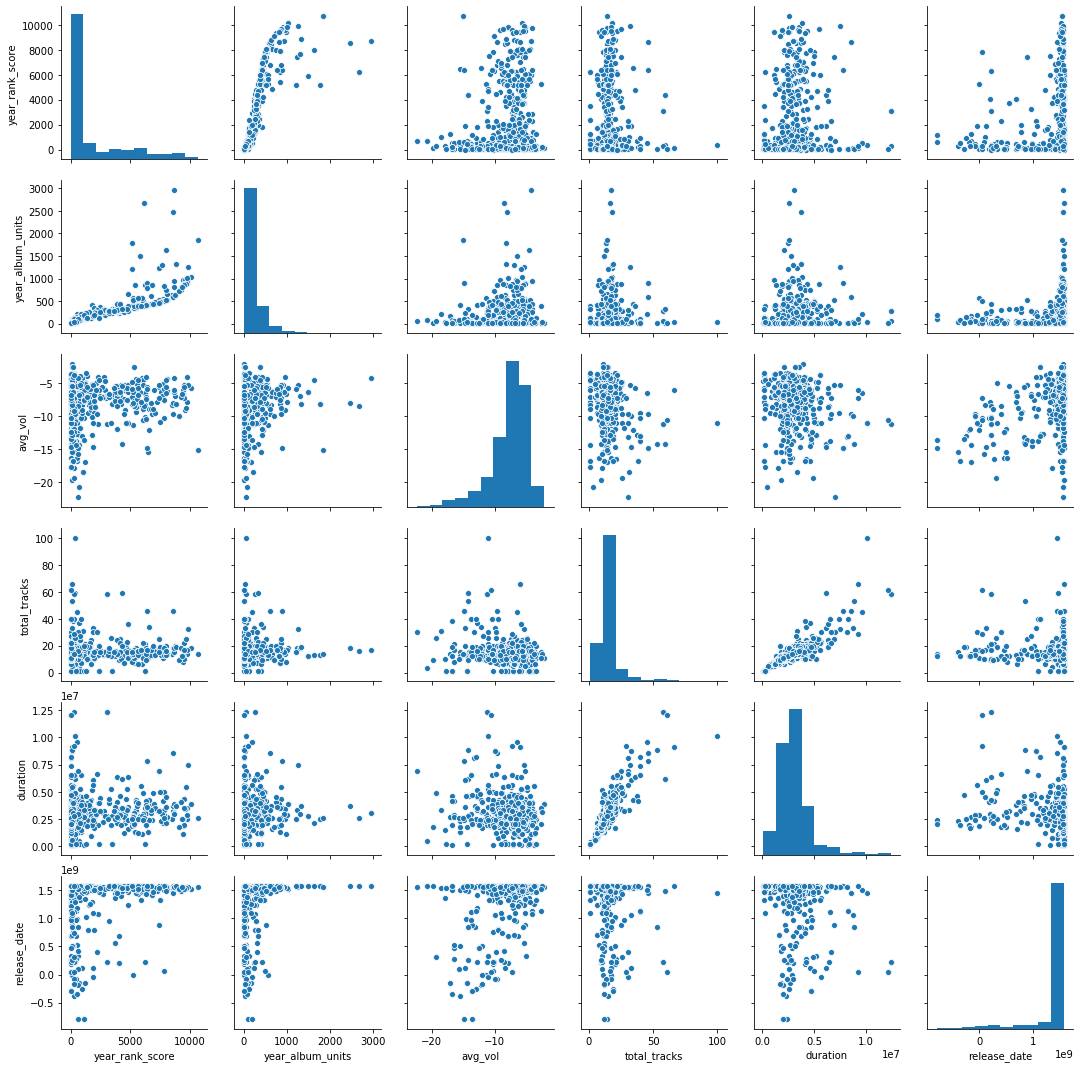

In [32]:
sns.pairplot(df_spot_rs_merge.iloc[:, 0:6])

## Save Data as it stands now

This seems like a good time to save data  
Using a pickle since csv wasn't correctly reproducing all values upon load  
call it `---_basic` to distinguish the first time I've saved data that looks like this

In [33]:
base_path = project_dir + '/data/interim/'
file_name = 'df_spot_rs_merge_basic.pickle'
if False: # make me true to save data
    save_pickle(df_spot_rs_merge, base_path + file_name)

In [34]:
base_path = project_dir + '/data/interim/'
file_name = 'df_spot_rs_merge_basic.pickle'
if False: # make me false to not load from pickls
    df_spot_rs_merge = load_pickle(base_path + file_name)

In [35]:
df_spot_rs_merge

,year_rank_score,year_album_units,avg_vol,total_tracks,duration,release_date,record_label,title_cleaned,caption_artist,album_id
0,134,12.7,-9.584857,14.0,2418639.0,1.565932e+09,other,"- Ugh, those feels again",Snoh Aalegra,42wtqDcTQlJJbUzAPBSwaK
1,48,5.9,-6.726071,14.0,3100819.0,1.333429e+09,other,10 Day,Chance The Rapper,6bUsvxMAuR8NXG2ujCU4yi
2,306,38.1,-12.741000,11.0,4550970.0,1.146200e+09,other,"10,000 Days",Tool,1fvWYcbjuycyHpzNPH1Vfk
3,25,5.3,-3.787812,16.0,3114311.0,1.558069e+09,other,11:11,Maluma,3YIUNL7qFE8NP3X3zaYSND
4,6484,408.4,-15.489545,11.0,1319918.0,1.503637e+09,other,17,XXXTentacion,5VdyJkLe3yvOs0l4xXbWp0
...,...,...,...,...,...,...,...,...,...,...
595,9394,822.7,-6.622000,12.0,2470209.0,1.549606e+09,Republic,"thank u, next",Ariana Grande,2fYhqwDWXjbpjaIJPEfKFw
596,47,5.6,-6.742455,11.0,2022586.0,1.570165e+09,other,uknowhatimsayin¿,Danny Brown,4G3BRVsGEpWzUdplFJ1VBl
597,2452,267.5,-7.248933,15.0,3236579.0,1.545545e+09,Atlantic Records,x,Ed Sheeran,7CjJb2mikwAWA1V6kewFBF
598,271,27.8,-3.707500,14.0,2827025.0,1.571980e+09,other,Épico,Lunay,46xbsFOp9g1WqTidQEs7YT


## Okay, now put it into a csv, and let whatever pandas loads from that csv be the official original processed dataset.

In [36]:
base_path = project_dir + '/data/processed/'
file_name = 'df_spot_rs_merge_basic.csv'
if False: # make me true to save the data
    df_spot_rs_merge.to_csv(base_path + file_name)

## put various basic information about this dataset into a dictionary file called 'df_spot_rs_merge_basic--info.txt'

In [37]:
df_spot_rs_merge.columns

Index(['year_rank_score', 'year_album_units', 'avg_vol', 'total_tracks',
       'duration', 'release_date', 'record_label', 'title_cleaned',
       'caption_artist', 'album_id'],
      dtype='object')

In [39]:
df_spot_rs_merge.dtypes

year_rank_score       int64
year_album_units    float64
avg_vol             float64
total_tracks        float64
duration            float64
release_date        float64
record_label         object
title_cleaned        object
caption_artist       object
album_id             object
dtype: object

In [43]:
information_about_dictionary = """
Columns:

Index(['year_rank_score', 'year_album_units', 'avg_vol', 'total_tracks',
       'duration', 'release_date', 'record_label', 'title_cleaned',
       'caption_artist', 'album_id'],
      dtype='object')

dtypes:      

year_rank_score       int64
year_album_units    float64
avg_vol             float64
total_tracks        float64
duration            float64
release_date        float64
record_label         object
title_cleaned        object
caption_artist       object
album_id             object
dtype: object      



column descriptions
year_rank_score       score derived from weekly rankings
year_album_units    sum of album units for all weeks on charts
avg_vol             average volume of all tracks on the album
total_tracks        total number of tracks on the album
duration            total duration of the album
release_date        date of album release, in number of seconds since unix epoch began
record_label         string: the record label (company) for the album. most are 'other'
title_cleaned        the title of the album, cleaned and standardized for the purposes of this project
caption_artist       the primary listed artise of the album
album_id             an id that spotify uses to identify albums

"""

In [46]:
base_path = project_dir + '/data/processed/'
file_name = 'df_spot_rs_merge_basic--info.txt'

if False: # make me true to save this file again
    with open (base_path + file_name, 'w') as outfile:
        outfile.write(information_about_dictionary)